## Machine Learning Classifiers Do Not Improve the Prediction of Academic Risk: Evidence from Australia

Sarah Cornell-Farrow and Robert Garrard (2019)

<a href="https://arxiv.org/abs/1807.07215">https://arxiv.org/abs/1807.07215</a>



This R notebook contains codes for replicating the results in our paper. For instructions on how to obtain a copy of the raw data used in this study, as well as the R code used to clean the data set for use in this notebook, please consult the README file.


This notebook was run on a computer with 12 cores and a gpu. We train our neural nets with Keras using a tensorflow-gpu backend.



# Sections

[Load and Preproccess Data](#sec:preprocessing)

[Sample Splitting](#sec:samplesplitting)


[Logistic Regression](#sec:logistic)
 
  * [Grade 3](#subsec:logisticGrade3)
  * [Grade 5+](#subsec:logisticGrade5plus)

[Elastic Net](#sec:elasticnet)

  * [Grade 3](#subsec:ENgrade3)
  * [Grade 5+](#subsec:ENgrade5plus)

[Decision Trees](#sec:decisiontrees)

  * [Grade 3](#subsec:DTgrade3)
  * [Grade 5+](#subsec:DTgrade5plus)
  
[Random Forest](#sec:randomforest)
  * [Grade3](#subsec:randomforest_grade3)
  * [Grade 5+](#subsec:randomforest_grade5plus)

[Neural Net](#sec:neural_net)
  * [Grade3](#subsec:randomforest_grade3)
  * [Grade 5+](#subsec:randomforest_grade5plus)


[ROC Curves](#sec:roc_weight)
 |
   

In [1]:
# Libraries
library(ggplot2)      # Plotting
library(ggthemes)     # Themes for ggplot2
library(caret)        # Create training/test sets
library(rpart)        # Recursive partitioning decision tree classifier
library(rpart.plot)   # Plot the tree
library(DMwR)         # Constructing SMOTE sample
library(pROC)         # Bulding ROC curves
library(glmnet)       # Elastic net classifier
library(doMC)         # Run elastic net in parallel
library(e1071)        # Confusion matrices
library(RColorBrewer) # Color palette
library(ranger)       # Random Forest 
library(cowplot)      # 4x4 plots
library(keras)        # Neural net



start.time <- Sys.time()
set.seed(2718)

Loading required package: lattice
Loading required package: grid
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘glmnet’

The following object is masked from ‘package:pROC’:

    auc

Loading required package: iterators
Loading required package: parallel

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggthemes’:

    theme_map

The following object is masked from ‘package:ggplot2’:

    ggsave



Elastic net can do cross-validation in parallel, so let's see how many cores we've got.

In [2]:
# Parallel backend
registerDoMC(detectCores() - 1)
print(paste("Using", getDoParWorkers(), "cores."))


[1] "Using 11 cores."


<a id='sec:preprocessing'></a>
## Load and Preprocess Data

Import the data set.

The raw data gets cleaned up by the script <i>clean_data.R</i>. That script outputs two clean data sets, one for regression and one for classification: <i>NAPLAN_data_reg.Rda</i>, in which the dependent variables are the raw NAPLAN scores; and <i>NAPLAN_data_clas.Rda</i>, in which the raw scores have been thresholded into 'At Standard' and 'Below Standard'. We want the classification one.

In [3]:
load('NAPLAN_data_clas.Rda')

summary(data)

           readrisk                 numrisk        grade      private    
 At Standard   :1874321   At Standard   :1849378   3:577865   0:1434717  
 Below Standard: 364733   Below Standard: 389676   5:558406   1: 804337  
                                                   7:537806              
                                                   9:564977              
                                                                         
                                                                         
                                                                         
      age        female      indigenous   LBOTE             state       
 Min.   : 7.00   0:1149664   0:2123079   0   :1679593   NSW    :716594  
 1st Qu.: 9.30   1:1089390   1: 115975   1   : 485032   VIC    :543907  
 Median :11.30                           NA's:  74429   QLD    :462894  
 Mean   :11.53                                          WA     :244938  
 3rd Qu.:13.60                             

Now let's take a look at how many students are performing below standard.

In [4]:
print("Performance on reading:")
print("total")
table(data$readrisk)
print("pertcent")
prop.table(table(data$readrisk))*100

print("Performancy on math:")
print("total")
table(data$numrisk)
print("percent")
prop.table(table(data$numrisk))*100

print("Transitions between performance states:")
print("Reading")
prop.table(table(data$readrisk, data$prevreadrisk))*100

print("Math")
prop.table(table(data$numrisk, data$prevnumrisk))*100


[1] "Performance on reading:"
[1] "total"



   At Standard Below Standard 
       1874321         364733 

[1] "pertcent"



   At Standard Below Standard 
       83.7104        16.2896 

[1] "Performancy on math:"
[1] "total"



   At Standard Below Standard 
       1849378         389676 

[1] "percent"



   At Standard Below Standard 
       82.5964        17.4036 

[1] "Transitions between performance states:"
[1] "Reading"


                
                 At Standard Below Standard
  At Standard      76.128363       6.558977
  Below Standard    8.940524       8.372136

[1] "Math"


                
                 At Standard Below Standard
  At Standard      75.208841       5.779475
  Below Standard   10.075253       8.936430

The variables <i>prevreadrisk</i> and <i>prevnumrisk</i> are only available for students in grade 5 and above, since grade 3 is the first time NAPLAN is sat. Since we want to exploit this predictor, split the data set into students in grade 3 and students in grades 5+

In [5]:
ix <- which(data$grade==3)         # In grade 3
iy <- setdiff(1:dim(data)[1], ix)  # In grade 5+

data.grade3 <- data[ix, ]
data.grade5plus <- data[iy, ]

For grade 3 data, the variables <i>grade</i>, <i>sameschool</i>, <i>prevreadrisk</i>, and <i>prevnumrisk</i> contain no variation, so we remove them. Further, remove observations which contain missing data (NAs). 


In [6]:
data.grade3 <- data.grade3[, -c(3, 10, 17, 18)]
data.grade3 <- data.grade3[complete.cases(data.grade3), ]
summary(data.grade3)
print("Data dimension")
dim(data.grade3)

           readrisk                numrisk       private         age        
 At Standard   :311807   At Standard   :313618   0:220407   Min.   : 7.000  
 Below Standard: 34010   Below Standard: 32199   1:125410   1st Qu.: 8.300  
                                                            Median : 8.600  
                                                            Mean   : 8.592  
                                                            3rd Qu.: 8.800  
                                                            Max.   :10.600  
                                                                            
 female     indigenous LBOTE          state        mumschool  mumhighed 
 0:177366   0:337160   0:266217   NSW    :110167   1: 11977   5: 83849  
 1:168451   1:  8657   1: 79600   VIC    :107934   2: 45362   6: 54637  
                                  QLD    : 67870   3: 31140   7:129956  
                                  WA     : 23640   4:257338   8: 77375  
                   

[1] "Data dimension"


[1] 345817     14

For grades 5+, there are no longer any grade 3 observations for the <i>grade</i> variable. So drop that level. Also retain only complete cases.

In [7]:
data.grade5plus <- data.grade5plus[complete.cases(data.grade5plus), ]
data.grade5plus$grade <- factor(data.grade5plus$grade)
summary(data.grade5plus)
print("Data dimension")
dim(data.grade5plus)

           readrisk                numrisk       grade      private   
 At Standard   :769606   At Standard   :758296   5:306954   0:481689  
 Below Standard:116786   Below Standard:128096   7:291292   1:404703  
                                                 9:288146             
                                                                      
                                                                      
                                                                      
                                                                      
      age        female     indigenous LBOTE          state        sameschool
 Min.   : 9.00   0:454850   0:865842   0:695474   NSW    :286765   0:318878  
 1st Qu.:10.80   1:431542   1: 20550   1:190918   VIC    :277539   1:567514  
 Median :12.50                                    QLD    :170811             
 Mean   :12.52                                    WA     : 75128             
 3rd Qu.:14.20                            

[1] "Data dimension"


[1] 886392     18

So far we have readrisk and numrisk together at the front of the data set. We want to predict these separately, so create subsets.

In [8]:
data.grade3.read <- data.grade3[, -2]
data.grade3.num <- data.grade3[, -1]

data.grade5plus.read <- data.grade5plus[, -2]
data.grade5plus.num <- data.grade5plus[, -1]

<a id='sec:samplesplitting'></a>
## Sample Splitting

2/3-1/3 split for each data set into training and test sets. 

Automatically the sampling will be stratified such that the training and test sets will have approximately the same class frequencies in the dependent variable; so there's no worry that the training/test set will be composed entirely of At Standard observations.

In [9]:
# Grade 3

# Reading
inTrain.grade3.read <- createDataPartition(y=data.grade3.read$readrisk, p=2/3, list=FALSE)
train.grade3.read <- data.grade3.read[inTrain.grade3.read, ]
test.grade3.read <- data.grade3.read[-inTrain.grade3.read, ]

# Numeracy
inTrain.grade3.num <- createDataPartition(y=data.grade3.num$numrisk, p=2/3, list=FALSE)
train.grade3.num <- data.grade3.num[inTrain.grade3.num, ]
test.grade3.num <- data.grade3.num[-inTrain.grade3.num, ]

# Grades 5+

# Reading
inTrain.grade5plus.read <- createDataPartition(y=data.grade5plus.read$readrisk, p=2/3, list=FALSE)
train.grade5plus.read <- data.grade5plus.read[inTrain.grade5plus.read, ]
test.grade5plus.read <- data.grade5plus.read[-inTrain.grade5plus.read, ]

# Numeracy
inTrain.grade5plus.num <- createDataPartition(y=data.grade5plus.num$numrisk, p=2/3, list=FALSE)
train.grade5plus.num <- data.grade5plus.num[inTrain.grade5plus.num, ]
test.grade5plus.num <- data.grade5plus.num[-inTrain.grade5plus.num, ]

print("Sample sizes:")
print("Grade 3 read")
print(dim(train.grade3.read))

print("Grade 5+ read")
print(dim(train.grade5plus.read))

print("Test set sizes")
print("Grade 3")
print(dim(test.grade3.read))
print("Grade 5+")
print(dim(test.grade5plus.read))

[1] "Sample sizes:"
[1] "Grade 3 read"
[1] 230546     13
[1] "Grade 5+ read"
[1] 590929     17
[1] "Test set sizes"
[1] "Grade 3"
[1] 115271     13
[1] "Grade 5+"
[1] 295463     17


Age is the only numeric variable. Standardize it in each set so that it has mean zero and variance one.

In [10]:
train.grade3.read$age <- scale(train.grade3.read$age)
train.grade3.num$age <- scale(train.grade3.num$age)
test.grade3.read$age <- scale(test.grade3.read$age)
test.grade3.num$age <- scale(test.grade3.num$age)

train.grade5plus.read$age <- scale(train.grade5plus.read$age)
train.grade5plus.num$age <- scale(train.grade5plus.num$age)
test.grade5plus.read$age <- scale(test.grade5plus.read$age)
test.grade5plus.num$age <- scale(test.grade5plus.num$age)

# There's definitely an easier way to do this, but I'm no good at R.

Data is now preprocessed, split into grade 3 students and grade 5+ students, and split into training and test sets. We begin the analysis by weighting observations to overcome the class imbalance problem. Later, we perform the same analysis on a SMOTE sample of the data.

<a id='sec:weightedobservations'></a>
## Observation weights

Weight each observation according to class frequency. Since the Below Standard class is about 1/6 as frequent, we want to avoid the classifier just classifying everyone as At Standard. We use weights such that the loss function to be minimized is

\begin{equation}
l(\mathbf{y}, \mathbf{\hat{y}}) = - \frac{1}{n} \sum_{i} w_{i} \{ y_{i} \log(\hat{y}_{i} + (1 - y_{i}) \log (1- \hat{y}_{i}) \}
\end{equation}

which is the standard binary cross-entropy loss function, but with misclassifications of one class weighted more heavily than the other.

In [11]:
weights.grade3.read <- ifelse(train.grade3.read$readrisk == "At Standard",
                             (1/table(train.grade3.read$readrisk)[1]*0.5),
                             (1/table(train.grade3.read$readrisk)[2]*0.5))

weights.grade3.num <- ifelse(train.grade3.num$numrisk == "At Standard",
                            (1/table(train.grade3.num$numrisk)[1]*0.5),
                            (1/table(train.grade3.num$numrisk)[2]*0.5))

weights.grade5plus.read <- ifelse(train.grade5plus.read$readrisk == "At Standard",
                             (1/table(train.grade5plus.read$readrisk)[1]*0.5),
                             (1/table(train.grade5plus.read$readrisk)[2]*0.5))

weights.grade5plus.num <- ifelse(train.grade5plus.num$numrisk == "At Standard",
                            (1/table(train.grade5plus.num$numrisk)[1]*0.5),
                            (1/table(train.grade5plus.num$numrisk)[2]*0.5))


<a id='sec:logistic'></a>
## Logistic Regression

Begin with a simple logistic estimator.

<a id='subsec:logisticGrade3'></a>
### Grade 3

In [12]:
# Literacy
logistic_model.grade3.read <- glm(readrisk ~.,
                                  family='binomial',
                                  data=train.grade3.read,
                                  weights=weights.grade3.read)
summary(logistic_model.grade3.read)

# Numeracy
logistic_model.grade3.num <- glm(numrisk ~.,
                                 family='binomial',
                                 data=train.grade3.num,
                                 weights=weights.grade3.num)
summary(logistic_model.grade3.num)


Call:
glm(formula = readrisk ~ ., family = "binomial", data = train.grade3.read, 
    weights = weights.grade3.read)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.003921  -0.001976  -0.001538  -0.001103   0.009959  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.984508  24.347328   0.040    0.968
private1    -0.082886   4.726230  -0.018    0.986
age         -0.074398   2.279775  -0.033    0.974
female1     -0.474802   4.381630  -0.108    0.914
indigenous1  0.727007  12.154218   0.060    0.952
LBOTE1       0.036505   5.717966   0.006    0.995
stateNSW    -0.170050  18.507868  -0.009    0.993
stateNT      0.663226  27.675475   0.024    0.981
stateQLD     0.125154  18.721945   0.007    0.995
stateSA      0.131324  20.087465   0.007    0.995
stateTAS     0.096570  22.698507   0.004    0.997
stateVIC    -0.293544  18.577495  -0.016    0.987
stateWA      0.174487  19.800050   0.009    0.993
mumschool2  -0.229450  11.928540 


Call:
glm(formula = numrisk ~ ., family = "binomial", data = train.grade3.num, 
    weights = weights.grade3.num)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.003775  -0.001983  -0.001556  -0.001131   0.009823  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.654666  24.169023   0.027    0.978
private1     0.006240   4.689025   0.001    0.999
age         -0.089803   2.260348  -0.040    0.968
female1     -0.006618   4.320531  -0.002    0.999
indigenous1  0.707352  12.190879   0.058    0.954
LBOTE1       0.181930   5.585571   0.033    0.974
stateNSW    -0.172554  18.427438  -0.009    0.993
stateNT      0.425013  27.892474   0.015    0.988
stateQLD     0.046064  18.650312   0.002    0.998
stateSA      0.205655  19.914164   0.010    0.992
stateTAS    -0.016372  22.727435  -0.001    0.999
stateVIC    -0.308627  18.491956  -0.017    0.987
stateWA      0.055790  19.755318   0.003    0.998
mumschool2  -0.207745  11.814672  -0

Get the predicted classes on the test sets.

In [13]:
# Predicted probabilities
logistic_preds.grade3.read <- predict(logistic_model.grade3.read, newdata=test.grade3.read[, -1], type='response')
logistic_preds.grade3.num <- predict(logistic_model.grade3.num, newdata=test.grade3.num[, -1], type='response')

# Predicted classes
pred_classes.grade3.read <- factor(logistic_preds.grade3.read>=0.5)
levels(pred_classes.grade3.read) <- c("At Standard", "Below Standard")

pred_classes.grade3.num <- factor(logistic_preds.grade3.num>=0.5)
levels(pred_classes.grade3.num) <- c("At Standard", "Below Standard")

Confusion matrices

In [14]:
confusionMatrix(pred_classes.grade3.read,
                test.grade3.read[, 1],
                positive='Below Standard')
confusionMatrix(pred_classes.grade3.num,
                test.grade3.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          65548           3458
  Below Standard       38387           7878
                                          
               Accuracy : 0.637           
                 95% CI : (0.6342, 0.6398)
    No Information Rate : 0.9017          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1372          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.69495         
            Specificity : 0.63066         
         Pos Pred Value : 0.17028         
         Neg Pred Value : 0.94989         
             Prevalence : 0.09834         
         Detection Rate : 0.06834         
   Detection Prevalence : 0.40136         
      Balanced Accuracy : 0.66281         
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          63833           3296
  Below Standard       40706           7437
                                          
               Accuracy : 0.6183          
                 95% CI : (0.6155, 0.6211)
    No Information Rate : 0.9069          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1184          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.69291         
            Specificity : 0.61061         
         Pos Pred Value : 0.15448         
         Neg Pred Value : 0.95090         
             Prevalence : 0.09311         
         Detection Rate : 0.06452         
   Detection Prevalence : 0.41765         
      Balanced Accuracy : 0.65176         
                                          
       'Positive' Class : Below Sta

ROC curves and estimate of area under the ROC curve. Later, ROC curves for each grade will be plotted on a single plot.

In [15]:
roc.logistic.grade3.read <- roc(test.grade3.read[, 1], logistic_preds.grade3.read)
roc.logistic.grade3.num <- roc(test.grade3.num[, 1], logistic_preds.grade3.num)

auc.logistic.grade3.read <- pROC::auc(roc.logistic.grade3.read)
auc.logistic.grade3.num <- pROC::auc(roc.logistic.grade3.num)

Confidence interval for AUC. The package <b>pROC</b> has the function 'var' to estimate the variance of AUC. We square root it, and add +/- 2 SEs to our AUC point estimate.

In [16]:
logistic.grade3.read.auc_se <- sqrt(var(roc.logistic.grade3.read))
logistic.grade3.num.auc_se <- sqrt(var(roc.logistic.grade3.num))


print("Logistic regression, grade 3")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.logistic.grade3.read))
print("95% confidence interval:")
print(paste0("(", auc.logistic.grade3.read - 1.96*logistic.grade3.read.auc_se,
             ", ",
             auc.logistic.grade3.read + 1.96*logistic.grade3.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.logistic.grade3.num))
print("95% confidence interval:")
print(paste0("(", auc.logistic.grade3.num - 1.96*logistic.grade3.num.auc_se,
             ", ",
             auc.logistic.grade3.num + 1.96*logistic.grade3.num.auc_se,
             ")"))

[1] "Logistic regression, grade 3"

[1] "Reading"
[1] "AUC =  0.72150110299788"
[1] "95% confidence interval:"
[1] "(0.716724032103049, 0.726278173892711)"

[1] "Numeracy"
[1] "AUC =  0.706939688076248"
[1] "95% confidence interval:"
[1] "(0.701960399640764, 0.711918976511732)"


<a id='subsec:logisticGrade5plus'></a>
### Grades 5+

Grade 5+ proceeds identically to grade 3.

In [17]:
# Literacy
logistic_model.grade5plus.read <- glm(readrisk ~.,
                                      family='binomial',
                                      data=train.grade5plus.read,
                                      weights=weights.grade5plus.read)
summary(logistic_model.grade5plus.read)

# Numeracy
logistic_model.grade5plus.num <- glm(numrisk ~.,
                                     family='binomial',
                                     data=train.grade5plus.num,
                                     weights=weights.grade5plus.num)
summary(logistic_model.grade5plus.num)


Call:
glm(formula = readrisk ~ ., family = "binomial", data = train.grade5plus.read, 
    weights = weights.grade5plus.read)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-0.0030319  -0.0009687  -0.0007446  -0.0005291   0.0059589  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)
(Intercept)                -0.004280  30.836944   0.000    1.000
grade7                     -0.331457  14.849681  -0.022    0.982
grade9                     -0.066402  26.860513  -0.002    0.998
private1                   -0.123970   5.312400  -0.023    0.981
age                         0.210367  11.070935   0.019    0.985
female1                    -0.393952   5.029786  -0.078    0.938
indigenous1                 0.399201  14.915446   0.027    0.979
LBOTE1                      0.141504   6.594187   0.021    0.983
stateNSW                   -0.055548  22.122359  -0.003    0.998
stateQLD                    0.128702  22.564544   0.006    0.995



Call:
glm(formula = numrisk ~ ., family = "binomial", data = train.grade5plus.num, 
    weights = weights.grade5plus.num)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-0.0030118  -0.0009975  -0.0007629  -0.0005379   0.0057354  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)
(Intercept)                 0.331935  29.858461   0.011    0.991
grade7                     -0.832208  14.805759  -0.056    0.955
grade9                     -0.731518  26.775277  -0.027    0.978
private1                   -0.076772   5.233785  -0.015    0.988
age                         0.223596  11.020751   0.020    0.984
female1                     0.307236   4.957434   0.062    0.951
indigenous1                 0.465215  14.770765   0.031    0.975
LBOTE1                      0.015160   6.546640   0.002    0.998
stateNSW                   -0.275739  20.691674  -0.013    0.989
stateQLD                   -0.290158  21.192916  -0.014    0.989
sta

In [18]:
# Predicted probabilities
logistic_preds.grade5plus.read <- predict(logistic_model.grade5plus.read,
                                          newdata=test.grade5plus.read[, -1], type='response')
logistic_preds.grade5plus.num <- predict(logistic_model.grade5plus.num,
                                         newdata=test.grade5plus.num[, -1], type='response')

# Predicted classes
pred_classes.grade5plus.read <- factor(logistic_preds.grade5plus.read>=0.5)
levels(pred_classes.grade5plus.read) <- c("At Standard", "Below Standard")

pred_classes.grade5plus.num <- factor(logistic_preds.grade5plus.num>=0.5)
levels(pred_classes.grade5plus.num) <- c("At Standard", "Below Standard")

In [19]:
confusionMatrix(pred_classes.grade5plus.read,
                test.grade5plus.read[, 1],
                positive='Below Standard')
confusionMatrix(pred_classes.grade5plus.num,
                test.grade5plus.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         218946          12605
  Below Standard       37589          26323
                                          
               Accuracy : 0.8301          
                 95% CI : (0.8288, 0.8315)
    No Information Rate : 0.8682          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4163          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.67620         
            Specificity : 0.85347         
         Pos Pred Value : 0.41186         
         Neg Pred Value : 0.94556         
             Prevalence : 0.13175         
         Detection Rate : 0.08909         
   Detection Prevalence : 0.21631         
      Balanced Accuracy : 0.76484         
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         215819          14367
  Below Standard       36946          28331
                                         
               Accuracy : 0.8263         
                 95% CI : (0.825, 0.8277)
    No Information Rate : 0.8555         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.4242         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.66352        
            Specificity : 0.85383        
         Pos Pred Value : 0.43401        
         Neg Pred Value : 0.93759        
             Prevalence : 0.14451        
         Detection Rate : 0.09589        
   Detection Prevalence : 0.22093        
      Balanced Accuracy : 0.75868        
                                         
       'Positive' Class : Below Standard 
           

In [20]:
roc.logistic.grade5plus.read <- roc(test.grade5plus.read[, 1], logistic_preds.grade5plus.read)
roc.logistic.grade5plus.num <- roc(test.grade5plus.num[, 1], logistic_preds.grade5plus.num)

auc.logistic.grade5plus.read <- pROC::auc(roc.logistic.grade5plus.read)
auc.logistic.grade5plus.num <- pROC::auc(roc.logistic.grade5plus.num)

In [21]:
logistic.grade5plus.read.auc_se <- sqrt(var(roc.logistic.grade5plus.read))
logistic.grade5plus.num.auc_se <- sqrt(var(roc.logistic.grade5plus.num))


print("Logistic regression, grade 5+")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.logistic.grade5plus.read))
print("95% confidence interval:")
print(paste0("(", auc.logistic.grade5plus.read - 1.96*logistic.grade5plus.read.auc_se,
             ", ",
             auc.logistic.grade5plus.read + 1.96*logistic.grade5plus.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.logistic.grade5plus.num))
print("95% confidence interval:")
print(paste0("(", auc.logistic.grade5plus.num - 1.96*logistic.grade5plus.num.auc_se,
             ", ",
             auc.logistic.grade5plus.num + 1.96*logistic.grade5plus.num.auc_se,
             ")"))

[1] "Logistic regression, grade 5+"

[1] "Reading"
[1] "AUC =  0.838780264015767"
[1] "95% confidence interval:"
[1] "(0.836552279979341, 0.841008248052193)"

[1] "Numeracy"
[1] "AUC =  0.832521795892323"
[1] "95% confidence interval:"
[1] "(0.830345833191683, 0.834697758592964)"


<a id='sec:elasticnet'></a>
## Elastic Net


The <b>glmnet</b> package requires a model matrix as input, rather than a data frame.

In [22]:
X.grade3.read <- model.matrix(readrisk ~., train.grade3.read)
X.grade3.num <- model.matrix(numrisk ~.,  train.grade3.num)

X.grade5plus.read <- model.matrix(readrisk ~., train.grade5plus.read)
X.grade5plus.num <- model.matrix(numrisk ~.,  train.grade5plus.num)

X.test.grade3.read <- model.matrix(readrisk~., test.grade3.read)
X.test.grade3.num <- model.matrix(numrisk~., test.grade3.num)


X.test.grade5plus.read <- model.matrix(readrisk~., test.grade5plus.read)
X.test.grade5plus.num <- model.matrix(numrisk~., test.grade5plus.num)

<a id='subsec:ENgrade3'></a>
### Grade 3

We set the elastic net mixing parameter, $\alpha$, to half so that the lasso and ridge penalties have the same weight. This parameter could be tuned, but the package doesn't offer that out-of-the-box so we'd have to do it manually. We've run it with .1 and .9 with no change to the result, so we don't think it's worth tuning it.

We run glmnet with the "type.measure='class'" option. This enforces binary cross-entropy loss, rather than the usual least squares loss.

In [23]:
# Elastic net parameter. Controlls relative strength of lasso and ridge penalties
alpha <- 0.5

t0 <- Sys.time()
EN_model.grade3.read <- cv.glmnet(x=X.grade3.read,
                                  y=train.grade3.read[, 1], #y.grade3.read,
                                  family="binomial",
                                  alpha=alpha,
                                  type.measure="class",
                                  weights=weights.grade3.read,
                                  parallel=T)
Sys.time() - t0

t0 <- Sys.time()
EN_model.grade3.num <- cv.glmnet(x=X.grade3.num,
                                 y=train.grade3.num[, 1], #y.grade3.num,
                                 family="binomial",
                                 alpha=alpha,
                                 type.measure="class",
                                 weights=weights.grade3.num,
                                 parallel=T)
Sys.time() - t0



Time difference of 38.60734 secs

Time difference of 35.55214 secs

In [24]:
coef(EN_model.grade3.read, s='lambda.min')
coef(EN_model.grade3.num, s='lambda.min')

34 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  0.95072722
(Intercept)  .         
private1    -0.07996263
age         -0.07279326
female1     -0.46696209
indigenous1  0.71740256
LBOTE1       0.03718366
stateNSW    -0.20698850
stateNT      0.59089586
stateQLD     0.07783417
stateSA      0.07602293
stateTAS     0.03511108
stateVIC    -0.32849662
stateWA      0.12038788
mumschool2  -0.16027825
mumschool3  -0.21495915
mumschool4  -0.45118216
mumhighed6  -0.13540301
mumhighed7  -0.61794384
mumhighed8   0.03040987
mumoccup2    0.01270433
mumoccup3   -0.01036519
mumoccup4    0.08174857
mumoccup8    0.09044337
dadschool2  -0.02968991
dadschool3  -0.17547776
dadschool4  -0.33047350
dadhighed6  -0.16000414
dadhighed7  -0.57548513
dadhighed8   .         
dadoccup2    0.06532472
dadoccup3    0.22233210
dadoccup4    0.42520783
dadoccup8    0.52374030

34 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  0.53837487
(Intercept)  .         
private1     .         
age         -0.08788445
female1      .         
indigenous1  0.69247281
LBOTE1       0.18239149
stateNSW    -0.15503526
stateNT      0.39302947
stateQLD     0.04817390
stateSA      0.19523598
stateTAS     .         
stateVIC    -0.28784475
stateWA      0.04799469
mumschool2  -0.10849122
mumschool3  -0.15536677
mumschool4  -0.38649305
mumhighed6  -0.10658212
mumhighed7  -0.61645476
mumhighed8   0.02154531
mumoccup2    .         
mumoccup3    .         
mumoccup4    0.11090708
mumoccup8    0.11513391
dadschool2  -0.05390869
dadschool3  -0.16364269
dadschool4  -0.33245094
dadhighed6  -0.12060706
dadhighed7  -0.50852715
dadhighed8   0.01807174
dadoccup2    0.05069448
dadoccup3    0.26329978
dadoccup4    0.50665953
dadoccup8    0.59429513

In [25]:
# Predicted probabilities
EN_preds.grade3.read <- predict(EN_model.grade3.read,
                                s='lambda.min',
                                newx=X.test.grade3.read,
                                type='response')
EN_preds.grade3.num <- predict(EN_model.grade3.num,
                               s='lambda.min',
                               newx=X.test.grade3.num,
                               type='response')

# Predicted classes
pred_classes.grade3.read <- factor(EN_preds.grade3.read>=0.5)
levels(pred_classes.grade3.read) <- c("At Standard", "Below Standard")

pred_classes.grade3.num <- factor(EN_preds.grade3.num>=0.5)
levels(pred_classes.grade3.num) <- c("At Standard", "Below Standard")

In [26]:
confusionMatrix(pred_classes.grade3.read,
                test.grade3.read[, 1],
                positive='Below Standard')
confusionMatrix(pred_classes.grade3.num,
                test.grade3.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          65388           3446
  Below Standard       38547           7890
                                          
               Accuracy : 0.6357          
                 95% CI : (0.6329, 0.6385)
    No Information Rate : 0.9017          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1366          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.69601         
            Specificity : 0.62912         
         Pos Pred Value : 0.16991         
         Neg Pred Value : 0.94994         
             Prevalence : 0.09834         
         Detection Rate : 0.06845         
   Detection Prevalence : 0.40285         
      Balanced Accuracy : 0.66257         
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          63689           3278
  Below Standard       40850           7455
                                        
               Accuracy : 0.6172        
                 95% CI : (0.6144, 0.62)
    No Information Rate : 0.9069        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.1182        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.69459       
            Specificity : 0.60924       
         Pos Pred Value : 0.15433       
         Neg Pred Value : 0.95105       
             Prevalence : 0.09311       
         Detection Rate : 0.06467       
   Detection Prevalence : 0.41905       
      Balanced Accuracy : 0.65191       
                                        
       'Positive' Class : Below Standard
                              

In [27]:
roc.EN.grade3.read <- roc(test.grade3.read[, 1], as.numeric(EN_preds.grade3.read))
roc.EN.grade3.num <- roc(test.grade3.num[, 1], as.numeric(EN_preds.grade3.num))

auc.EN.grade3.read <- pROC::auc(roc.EN.grade3.read)
auc.EN.grade3.num <- pROC::auc(roc.EN.grade3.num)

In [28]:
EN.grade3.read.auc_se <- sqrt(var(roc.EN.grade3.read))
EN.grade3.num.auc_se <- sqrt(var(roc.EN.grade3.num))


print("Elastic Net regression, grade 3")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.EN.grade3.read))
print("95% confidence interval:")
print(paste0("(", auc.EN.grade3.read - 1.96*EN.grade3.read.auc_se,
             ", ",
             auc.EN.grade3.read + 1.96*EN.grade3.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.EN.grade3.num))
print("95% confidence interval:")
print(paste0("(", auc.EN.grade3.num - 1.96*EN.grade3.num.auc_se,
             ", ",
             auc.EN.grade3.num + 1.96*EN.grade3.num.auc_se,
             ")"))

[1] "Elastic Net regression, grade 3"

[1] "Reading"
[1] "AUC =  0.721329931911125"
[1] "95% confidence interval:"
[1] "(0.716551200644492, 0.726108663177758)"

[1] "Numeracy"
[1] "AUC =  0.706776822463845"
[1] "95% confidence interval:"
[1] "(0.701797428748262, 0.711756216179429)"


<a id='subsec:ENgrade5plus'></a>
### Grade 5

In [29]:
t0 <- Sys.time()
EN_model.grade5plus.read <- cv.glmnet(x=X.grade5plus.read,
                                      y=train.grade5plus.read[, 1], #y.grade5plus.read,
                                      family="binomial",
                                      alpha=alpha,
                                      type.measure="class",
                                      weights=weights.grade5plus.read,
                                      parallel=T)
Sys.time() - t0

t0 <- Sys.time()
EN_model.grade5plus.num <- cv.glmnet(x=X.grade5plus.num,
                                 y=train.grade5plus.num[, 1], #y.grade5plus.num,
                                 family="binomial",
                                 alpha=alpha,
                                 type.measure="class",
                                 weights=weights.grade5plus.num,
                                 parallel=T)
Sys.time() - t0



Time difference of 2.239846 mins

Time difference of 3.214388 mins

In [30]:
coef(EN_model.grade5plus.read, s='lambda.min')
coef(EN_model.grade5plus.num, s='lambda.min')

39 x 1 sparse Matrix of class "dgCMatrix"
                                     1
(Intercept)                -0.08688305
(Intercept)                 .         
grade7                     -0.26095441
grade9                      0.05096113
private1                   -0.12297276
age                         0.16013991
female1                    -0.38959576
indigenous1                 0.38881633
LBOTE1                      0.13982003
stateNSW                   -0.05404376
stateNT                     .         
stateQLD                    0.10862916
stateSA                     0.07360182
stateTAS                    .         
stateVIC                    .         
stateWA                     0.03810633
sameschool1                -0.21735937
mumschool2                 -0.02446997
mumschool3                 -0.07429947
mumschool4                 -0.24726836
mumhighed6                 -0.10981198
mumhighed7                 -0.45459045
mumhighed8                  0.01939618
mumoccup2             

39 x 1 sparse Matrix of class "dgCMatrix"
                                      1
(Intercept)                -0.033899233
(Intercept)                 .          
grade7                     -0.636428093
grade9                     -0.371656159
private1                   -0.076924025
age                         0.078175749
female1                     0.294170092
indigenous1                 0.454005547
LBOTE1                      0.005147201
stateNSW                   -0.090686164
stateNT                     .          
stateQLD                   -0.139731336
stateSA                     0.094104651
stateTAS                    0.046929848
stateVIC                    .          
stateWA                    -0.074252731
sameschool1                -0.276966138
mumschool2                  .          
mumschool3                 -0.058856857
mumschool4                 -0.243538698
mumhighed6                 -0.072177243
mumhighed7                 -0.476566139
mumhighed8                 -0.00313308

In [31]:
# Predicted probabilities
EN_preds.grade5plus.read <- predict(EN_model.grade5plus.read,
                                    s='lambda.min',
                                    newx=X.test.grade5plus.read,
                                    type='response')
EN_preds.grade5plus.num <- predict(EN_model.grade5plus.num,
                                   s='lambda.min',
                                   newx=X.test.grade5plus.num,
                                   type='response')

# Predicted classes
pred_classes.grade5plus.read <- factor(EN_preds.grade5plus.read>=0.5)
levels(pred_classes.grade5plus.read) <- c("At Standard", "Below Standard")

pred_classes.grade5plus.num <- factor(EN_preds.grade5plus.num>=0.5)
levels(pred_classes.grade5plus.num) <- c("At Standard", "Below Standard")

In [32]:
confusionMatrix(pred_classes.grade5plus.read,
                test.grade5plus.read[, 1],
                positive='Below Standard')
confusionMatrix(pred_classes.grade5plus.num,
                test.grade5plus.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         219228          12659
  Below Standard       37307          26269
                                          
               Accuracy : 0.8309          
                 95% CI : (0.8295, 0.8322)
    No Information Rate : 0.8682          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4173          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.67481         
            Specificity : 0.85457         
         Pos Pred Value : 0.41319         
         Neg Pred Value : 0.94541         
             Prevalence : 0.13175         
         Detection Rate : 0.08891         
   Detection Prevalence : 0.21517         
      Balanced Accuracy : 0.76469         
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         216237          14468
  Below Standard       36528          28230
                                         
               Accuracy : 0.8274         
                 95% CI : (0.826, 0.8288)
    No Information Rate : 0.8555         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.4253         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.66116        
            Specificity : 0.85549        
         Pos Pred Value : 0.43593        
         Neg Pred Value : 0.93729        
             Prevalence : 0.14451        
         Detection Rate : 0.09554        
   Detection Prevalence : 0.21917        
      Balanced Accuracy : 0.75832        
                                         
       'Positive' Class : Below Standard 
           

In [33]:
roc.EN.grade5plus.read <- roc(test.grade5plus.read[, 1], as.numeric(EN_preds.grade5plus.read))
roc.EN.grade5plus.num <- roc(test.grade5plus.num[, 1], as.numeric(EN_preds.grade5plus.num))

auc.EN.grade5plus.read <- pROC::auc(roc.EN.grade5plus.read)
auc.EN.grade5plus.num <- pROC::auc(roc.EN.grade5plus.num)

In [34]:
EN.grade5plus.read.auc_se <- sqrt(var(roc.EN.grade5plus.read))
EN.grade5plus.num.auc_se <- sqrt(var(roc.EN.grade5plus.num))


print("Elastic Net regression, grade 5+")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.EN.grade5plus.read))
print("95% confidence interval:")
print(paste0("(", auc.EN.grade5plus.read - 1.96*EN.grade5plus.read.auc_se,
             ", ",
             auc.EN.grade5plus.read + 1.96*EN.grade5plus.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.EN.grade5plus.num))
print("95% confidence interval:")
print(paste0("(", auc.EN.grade5plus.num - 1.96*EN.grade5plus.num.auc_se,
             ", ",
             auc.EN.grade5plus.num + 1.96*EN.grade5plus.num.auc_se,
             ")"))

[1] "Elastic Net regression, grade 5+"

[1] "Reading"
[1] "AUC =  0.838807213431849"
[1] "95% confidence interval:"
[1] "(0.836579028310337, 0.841035398553362)"

[1] "Numeracy"
[1] "AUC =  0.832370128585906"
[1] "95% confidence interval:"
[1] "(0.830192336240765, 0.834547920931047)"


<a id='sec:decisiontrees'></a>
## Decision Trees

<a id='subsec:DTgrade3'></a>
### Grade 3

In [35]:
cart_model.grade3.read <- rpart(readrisk ~.,
                                data=train.grade3.read,
                                weights=weights.grade3.read)

cart_model.grade3.num <- rpart(numrisk ~.,
                               data=train.grade3.num,
                               weights=weights.grade3.num)

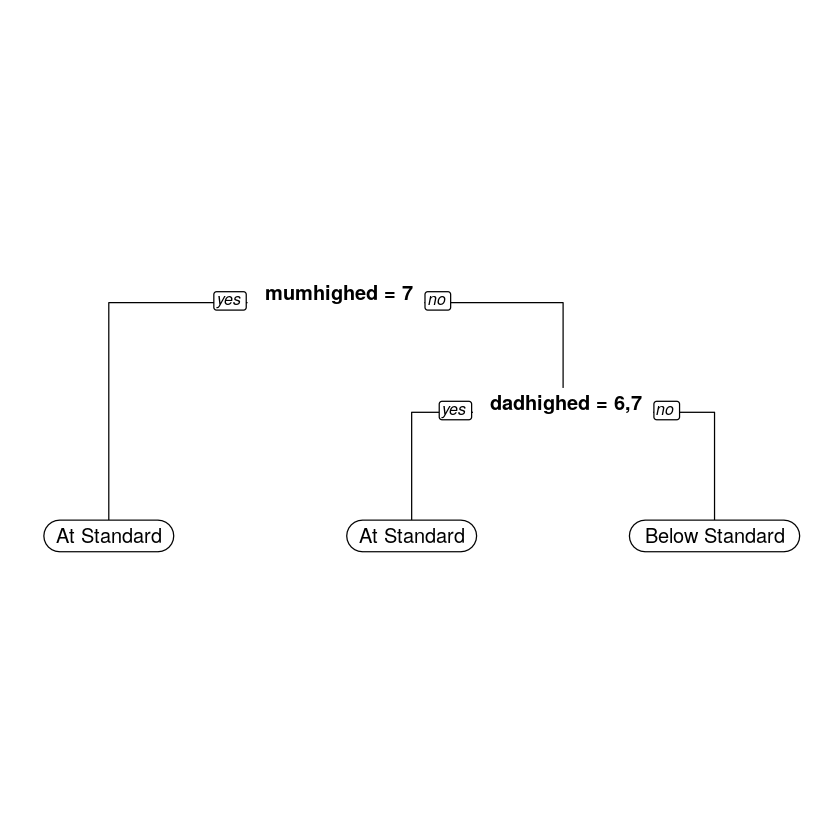

png 
  2

png 
  2

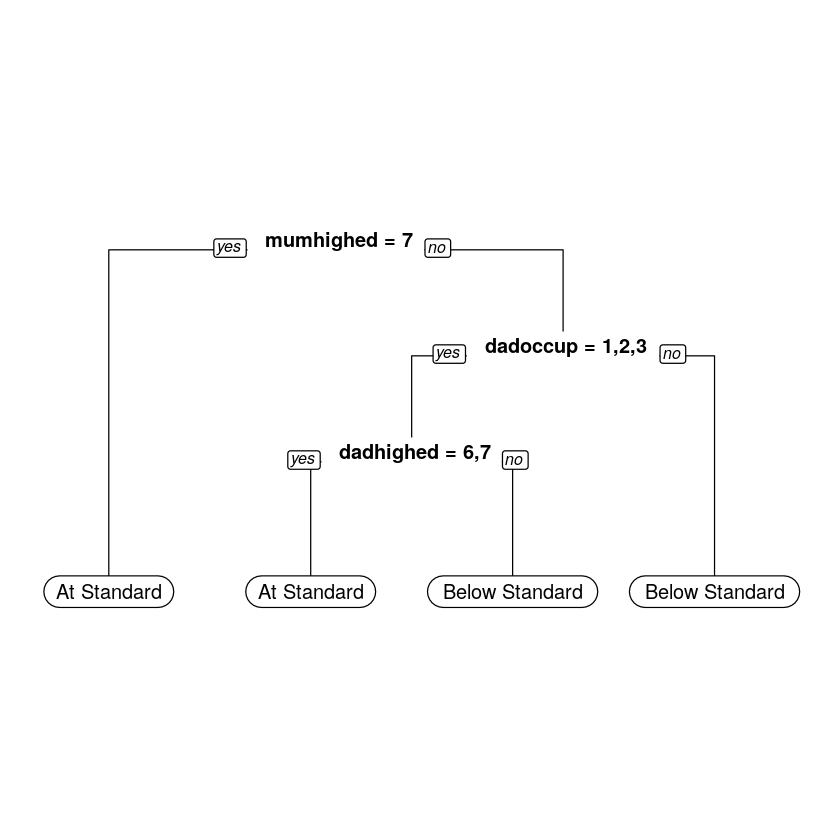

In [36]:
options(repr.plot.width=7, repr.plot.height=7)

# Plot the tree

prp(cart_model.grade3.read,
    fallen.leaves=T,
    yesno=2,
    varlen=0)
prp(cart_model.grade3.num,
    fallen.leaves=T,
    yesno=2,
    varlen=0)


pdf('cart_grade3_read.pdf')
prp(cart_model.grade3.read,
    fallen.leaves=T,
    yesno=2,
    varlen=0)
dev.off()
pdf('cart_grade3_num.pdf')
prp(cart_model.grade3.num,
    fallen.leaves=T,
    yesno=2,
    varlen=0)
dev.off()

In [37]:
# Predicted probabilities
cart_preds.grade3.read <- predict(cart_model.grade3.read,
                                  newdata=test.grade3.read[, -1], type='prob')[, 2]
cart_preds.grade3.num <- predict(cart_model.grade3.num,
                                 newdata=test.grade3.num[, -1], type='prob')[, 2]

# Predicted classes
pred_classes.grade3.read <- predict(cart_model.grade3.read, newdata=test.grade3.read[, -1], type='class')
pred_classes.grade3.num <- predict(cart_model.grade3.num, newdata=test.grade3.num[, -1], type='class')

In [38]:
confusionMatrix(pred_classes.grade3.read,
                test.grade3.read[, 1],
                positive='Below Standard')
confusionMatrix(pred_classes.grade3.num,
                test.grade3.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          60687           3379
  Below Standard       43248           7957
                                          
               Accuracy : 0.5955          
                 95% CI : (0.5927, 0.5983)
    No Information Rate : 0.9017          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1114          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.70192         
            Specificity : 0.58389         
         Pos Pred Value : 0.15539         
         Neg Pred Value : 0.94726         
             Prevalence : 0.09834         
         Detection Rate : 0.06903         
   Detection Prevalence : 0.44421         
      Balanced Accuracy : 0.64291         
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          58063           3028
  Below Standard       46476           7705
                                          
               Accuracy : 0.5705          
                 95% CI : (0.5677, 0.5734)
    No Information Rate : 0.9069          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.097           
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.71788         
            Specificity : 0.55542         
         Pos Pred Value : 0.14221         
         Neg Pred Value : 0.95043         
             Prevalence : 0.09311         
         Detection Rate : 0.06684         
   Detection Prevalence : 0.47003         
      Balanced Accuracy : 0.63665         
                                          
       'Positive' Class : Below Sta

In [39]:
roc.cart.grade3.read <- roc(factor(test.grade3.read[, 1]), cart_preds.grade3.read)
roc.cart.grade3.num <- roc(factor(test.grade3.num[, 1]), cart_preds.grade3.num)

auc.cart.grade3.read <- pROC::auc(roc.cart.grade3.read)
auc.cart.grade3.num <- pROC::auc(roc.cart.grade3.num)

In [40]:
cart.grade3.read.auc_se <- sqrt(var(roc.cart.grade3.read))
cart.grade3.num.auc_se <- sqrt(var(roc.cart.grade3.num))


print("Decision Tree, grade 3")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.cart.grade3.read))
print("95% confidence interval:")
print(paste0("(", auc.cart.grade3.read - 1.96*cart.grade3.read.auc_se,
             ", ",
             auc.cart.grade3.read + 1.96*cart.grade3.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.cart.grade3.num))
print("95% confidence interval:")
print(paste0("(", auc.cart.grade3.num - 1.96*cart.grade3.num.auc_se,
             ", ",
             auc.cart.grade3.num + 1.96*cart.grade3.num.auc_se,
             ")"))

[1] "Decision Tree, grade 3"

[1] "Reading"
[1] "AUC =  0.655152873116133"
[1] "95% confidence interval:"
[1] "(0.650724809407479, 0.659580936824788)"

[1] "Numeracy"
[1] "AUC =  0.667791233022461"
[1] "95% confidence interval:"
[1] "(0.662763628268862, 0.67281883777606)"


<a id='subsec:DTgrade5plus'></a>
### Grade 5+

In [41]:
cart_model.grade5plus.read <- rpart(readrisk ~.,
                                    data=train.grade5plus.read,
                                    weights=weights.grade5plus.read)

cart_model.grade5plus.num <- rpart(numrisk ~.,
                                   data=train.grade5plus.num,
                                   weights=weights.grade5plus.num)

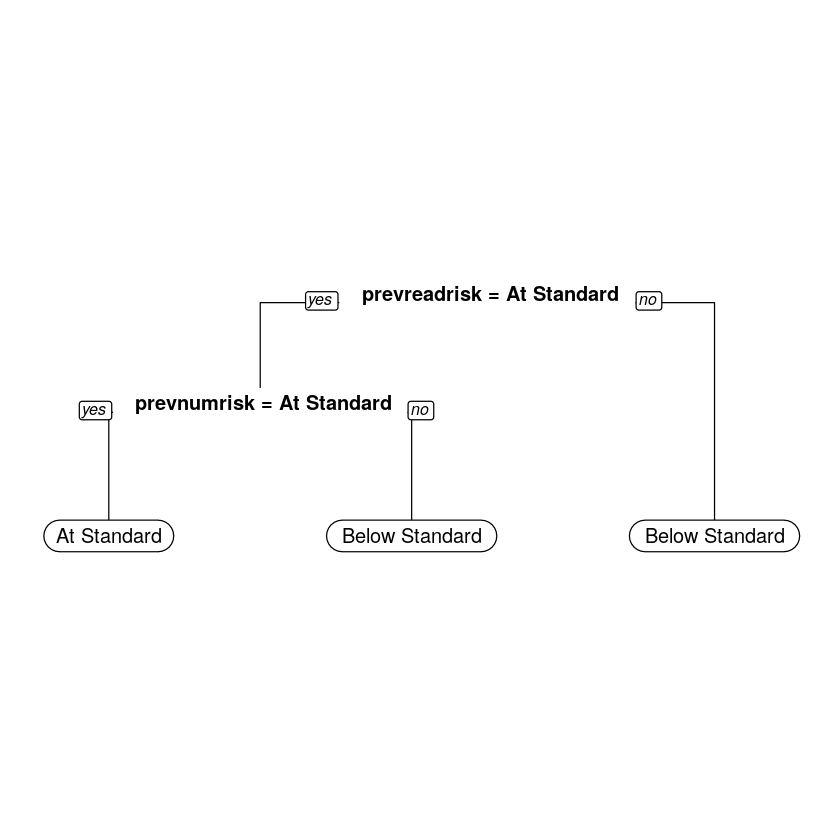

png 
  2

png 
  2

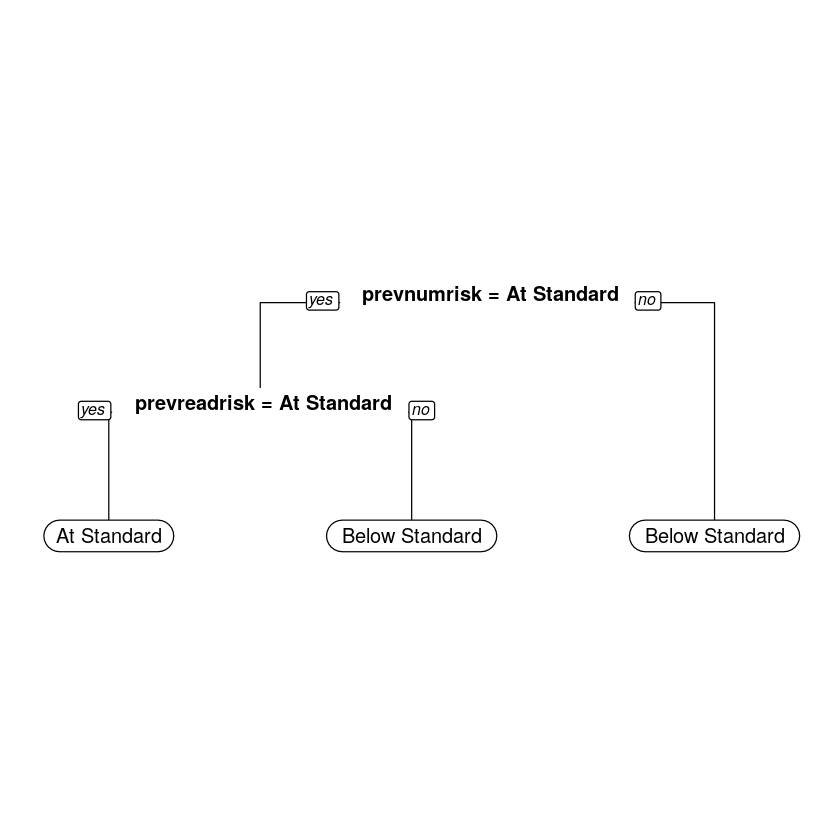

In [42]:
# Plot the tree
prp(cart_model.grade5plus.read,
    fallen.leaves=T,
    yesno=2,
    varlen=0,
    faclen=0)
prp(cart_model.grade5plus.num,
    fallen.leaves=T,
    yesno=2,
    varlen=0,
    faclen=0)

pdf('cart_grade5plus_read.pdf')
prp(cart_model.grade5plus.read,
    fallen.leaves=T,
    yesno=2,
    varlen=0,
    faclen=0)
dev.off()
pdf('cart_grade5plus_num.pdf')
prp(cart_model.grade5plus.num,
    fallen.leaves=T,
    yesno=2,
    varlen=0,
    faclen=0)
dev.off()

In [43]:
# Predicted probabilities
cart_preds.grade5plus.read <- predict(cart_model.grade5plus.read,
                                      newdata=test.grade5plus.read[, -1],
                                      type='prob')[, 2]
cart_preds.grade5plus.num <- predict(cart_model.grade5plus.num,
                                     newdata=test.grade5plus.num[, -1],
                                     type='prob')[, 2]

# Predicted classes
pred_classes.grade5plus.read <- predict(cart_model.grade5plus.read,
                                        newdata=test.grade5plus.read[, -1],
                                        type='class')
pred_classes.grade5plus.num <- predict(cart_model.grade5plus.num,
                                       newdata=test.grade5plus.num[, -1],
                                       type='class')

In [44]:
confusionMatrix(pred_classes.grade5plus.read, test.grade5plus.read[, 1])
confusionMatrix(pred_classes.grade5plus.num, test.grade5plus.num[, 1])

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         227042          14276
  Below Standard       29493          24652
                                          
               Accuracy : 0.8519          
                 95% CI : (0.8506, 0.8531)
    No Information Rate : 0.8682          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4446          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8850          
            Specificity : 0.6333          
         Pos Pred Value : 0.9408          
         Neg Pred Value : 0.4553          
             Prevalence : 0.8682          
         Detection Rate : 0.7684          
   Detection Prevalence : 0.8167          
      Balanced Accuracy : 0.7592          
                                          
       'Positive' Class : At Standa

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         224597          16466
  Below Standard       28168          26232
                                          
               Accuracy : 0.8489          
                 95% CI : (0.8476, 0.8502)
    No Information Rate : 0.8555          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4515          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8886          
            Specificity : 0.6144          
         Pos Pred Value : 0.9317          
         Neg Pred Value : 0.4822          
             Prevalence : 0.8555          
         Detection Rate : 0.7602          
   Detection Prevalence : 0.8159          
      Balanced Accuracy : 0.7515          
                                          
       'Positive' Class : At Standa

In [45]:
roc.cart.grade5plus.read <- roc(test.grade5plus.read[, 1], cart_preds.grade5plus.read)
roc.cart.grade5plus.num <- roc(test.grade5plus.num[, 1], cart_preds.grade5plus.num)

auc.cart.grade5plus.read <- pROC::auc(roc.cart.grade5plus.read)
auc.cart.grade5plus.num <- pROC::auc(roc.cart.grade5plus.num)

In [46]:
cart.grade5plus.read.auc_se <- sqrt(var(roc.cart.grade5plus.read))
cart.grade5plus.num.auc_se <- sqrt(var(roc.cart.grade5plus.num))


print("Decision Tree, grade 5+")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.cart.grade5plus.read))
print("95% confidence interval:")
print(paste0("(", auc.cart.grade5plus.read - 1.96*cart.grade5plus.read.auc_se,
             ", ",
             auc.cart.grade5plus.read + 1.96*cart.grade5plus.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.cart.grade5plus.num))
print("95% confidence interval:")
print(paste0("(", auc.cart.grade5plus.num - 1.96*cart.grade5plus.num.auc_se,
             ", ",
             auc.cart.grade5plus.num + 1.96*cart.grade5plus.num.auc_se,
             ")"))

[1] "Decision Tree, grade 5+"

[1] "Reading"
[1] "AUC =  0.767313353417619"
[1] "95% confidence interval:"
[1] "(0.764786722637736, 0.769839984197502)"

[1] "Numeracy"
[1] "AUC =  0.760718491240406"
[1] "95% confidence interval:"
[1] "(0.75827241780646, 0.763164564674352)"


<a id='sec:randomforest'></a>
# Random Forest

<a id='subsec:randomforest_grade3'></a>
### Grade 3


In [47]:
n.trees <- 500

t0 <- Sys.time()
RF_model.grade3.read <- ranger(readrisk ~.,
                               data=train.grade3.read,
                               num.trees=n.trees,
                               case.weights=weights.grade3.read,
                               probability=TRUE)

Sys.time() - t0
RF_model.grade3.num <- ranger(numrisk ~.,
                              data=train.grade3.num,
                              num.trees=n.trees,
                              case.weights=weights.grade3.num,
                              probability=TRUE)
Sys.time() - t0

Time difference of 30.36731 secs

Time difference of 59.72921 secs

In [48]:
RF_preds.grade3.read <- predict(RF_model.grade3.read,
                                data=test.grade3.read[, -1], type='response')$predictions[, 2]
pred_classes.grade3.read <- factor(RF_preds.grade3.read>= 0.5)
levels(pred_classes.grade3.read) <- c("At Standard", "Below Standard")

RF_preds.grade3.num <- predict(RF_model.grade3.num,
                               data=test.grade3.num[, -1], type='response')$predictions[, 2]
pred_classes.grade3.num <- factor(RF_preds.grade3.num>= 0.5)
levels(pred_classes.grade3.num) <- c("At Standard", "Below Standard")

In [49]:
confusionMatrix(pred_classes.grade3.read,
                test.grade3.read[, 1],
                positive='Below Standard')
confusionMatrix(pred_classes.grade3.num,
                test.grade3.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          81828           6129
  Below Standard       22107           5207
                                          
               Accuracy : 0.755           
                 95% CI : (0.7526, 0.7575)
    No Information Rate : 0.9017          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1515          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.45933         
            Specificity : 0.78730         
         Pos Pred Value : 0.19063         
         Neg Pred Value : 0.93032         
             Prevalence : 0.09834         
         Detection Rate : 0.04517         
   Detection Prevalence : 0.23695         
      Balanced Accuracy : 0.62332         
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          83887           6349
  Below Standard       20652           4384
                                          
               Accuracy : 0.7658          
                 95% CI : (0.7633, 0.7682)
    No Information Rate : 0.9069          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.132           
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.40846         
            Specificity : 0.80245         
         Pos Pred Value : 0.17511         
         Neg Pred Value : 0.92964         
             Prevalence : 0.09311         
         Detection Rate : 0.03803         
   Detection Prevalence : 0.21719         
      Balanced Accuracy : 0.60545         
                                          
       'Positive' Class : Below Sta

In [50]:
roc.rf.grade3.read <- roc(factor(test.grade3.read[, 1]), RF_preds.grade3.read)
roc.rf.grade3.num <- roc(factor(test.grade3.num[, 1]), RF_preds.grade3.num)

auc.rf.grade3.read <- pROC::auc(roc.rf.grade3.read)
auc.rf.grade3.num <- pROC::auc(roc.rf.grade3.num)

In [51]:
rf.grade3.read.auc_se <- sqrt(var(roc.rf.grade3.read))
rf.grade3.num.auc_se <- sqrt(var(roc.rf.grade3.num))


print("Decision Tree, grade 3")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.rf.grade3.read))
print("95% confidence interval:")
print(paste0("(", auc.rf.grade3.read - 1.96*rf.grade3.read.auc_se,
             ", ",
             auc.rf.grade3.read + 1.96*rf.grade3.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.rf.grade3.num))
print("95% confidence interval:")
print(paste0("(", auc.rf.grade3.num - 1.96*rf.grade3.num.auc_se,
             ", ",
             auc.rf.grade3.num + 1.96*rf.grade3.num.auc_se,
             ")"))

[1] "Decision Tree, grade 3"

[1] "Reading"
[1] "AUC =  0.696772410125228"
[1] "95% confidence interval:"
[1] "(0.691853419398387, 0.701691400852069)"

[1] "Numeracy"
[1] "AUC =  0.681156613704939"
[1] "95% confidence interval:"
[1] "(0.676053257662628, 0.68625996974725)"


<a id='subsec:randomforest_grade5plus'></a>
### Grade 5+

In [52]:
t0 <- Sys.time()
RF_model.grade5plus.read <- ranger(readrisk ~.,
                               data=train.grade5plus.read,
                               num.trees=n.trees,
                               case.weights=weights.grade5plus.read,
                               probability=TRUE)
Sys.time() - t0

Growing trees.. Progress: 24%. Estimated remaining time: 1 minute, 38 seconds.
Growing trees.. Progress: 48%. Estimated remaining time: 1 minute, 6 seconds.
Growing trees.. Progress: 73%. Estimated remaining time: 34 seconds.
Growing trees.. Progress: 99%. Estimated remaining time: 0 seconds.


Time difference of 2.435911 mins

In [53]:

RF_model.grade5plus.num <- ranger(numrisk ~.,
                              data=train.grade5plus.num,
                              num.trees=n.trees,
                              case.weights=weights.grade5plus.num,
                              probability=TRUE)
Sys.time() - t0

Growing trees.. Progress: 24%. Estimated remaining time: 1 minute, 40 seconds.
Growing trees.. Progress: 50%. Estimated remaining time: 1 minute, 2 seconds.
Growing trees.. Progress: 76%. Estimated remaining time: 29 seconds.


Time difference of 4.84364 mins

In [54]:
RF_preds.grade5plus.read <- predict(RF_model.grade5plus.read,
                                data=test.grade5plus.read[, -1], type='response')$predictions[, 2]
pred_classes.grade5plus.read <- factor(RF_preds.grade5plus.read>= 0.5)
levels(pred_classes.grade5plus.read) <- c("At Standard", "Below Standard")

RF_preds.grade5plus.num <- predict(RF_model.grade5plus.num,
                               data=test.grade5plus.num[, -1], type='response')$predictions[, 2]
pred_classes.grade5plus.num <- factor(RF_preds.grade5plus.num>= 0.5)
levels(pred_classes.grade5plus.num) <- c("At Standard", "Below Standard")

In [55]:
confusionMatrix(pred_classes.grade5plus.read,
                test.grade5plus.read[, 1],
                positive='Below Standard')
confusionMatrix(pred_classes.grade5plus.num,
                test.grade5plus.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         223744          14275
  Below Standard       32791          24653
                                         
               Accuracy : 0.8407         
                 95% CI : (0.8394, 0.842)
    No Information Rate : 0.8682         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.4206         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.63330        
            Specificity : 0.87218        
         Pos Pred Value : 0.42917        
         Neg Pred Value : 0.94003        
             Prevalence : 0.13175        
         Detection Rate : 0.08344        
   Detection Prevalence : 0.19442        
      Balanced Accuracy : 0.75274        
                                         
       'Positive' Class : Below Standard 
           

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         220715          16027
  Below Standard       32050          26671
                                          
               Accuracy : 0.8373          
                 95% CI : (0.8359, 0.8386)
    No Information Rate : 0.8555          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4307          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.62464         
            Specificity : 0.87320         
         Pos Pred Value : 0.45420         
         Neg Pred Value : 0.93230         
             Prevalence : 0.14451         
         Detection Rate : 0.09027         
   Detection Prevalence : 0.19874         
      Balanced Accuracy : 0.74892         
                                          
       'Positive' Class : Below Sta

In [56]:
roc.rf.grade5plus.read <- roc(factor(test.grade5plus.read[, 1]), RF_preds.grade5plus.read)
roc.rf.grade5plus.num <- roc(factor(test.grade5plus.num[, 1]), RF_preds.grade5plus.num)

auc.rf.grade5plus.read <- pROC::auc(roc.rf.grade5plus.read)
auc.rf.grade5plus.num <- pROC::auc(roc.rf.grade5plus.num)

In [57]:
rf.grade5plus.read.auc_se <- sqrt(var(roc.rf.grade5plus.read))
rf.grade5plus.num.auc_se <- sqrt(var(roc.rf.grade5plus.num))


print("Decision Tree, grade 3")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.rf.grade5plus.read))
print("95% confidence interval:")
print(paste0("(", auc.rf.grade5plus.read - 1.96*rf.grade5plus.read.auc_se,
             ", ",
             auc.rf.grade5plus.read + 1.96*rf.grade5plus.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.rf.grade5plus.num))
print("95% confidence interval:")
print(paste0("(", auc.rf.grade5plus.num - 1.96*rf.grade5plus.num.auc_se,
             ", ",
             auc.rf.grade5plus.num + 1.96*rf.grade5plus.num.auc_se,
             ")"))

[1] "Decision Tree, grade 3"

[1] "Reading"
[1] "AUC =  0.828454843844703"
[1] "95% confidence interval:"
[1] "(0.82614412073274, 0.830765566956665)"

[1] "Numeracy"
[1] "AUC =  0.82252722228793"
[1] "95% confidence interval:"
[1] "(0.820276595012077, 0.824777849563782)"


<a id='sec:neural_net'></a>
## Neural Net

We're going to use the Keras package with a tensorflow-gpu backend to estimate a multilayer perceptron with 4 hidden layers. Hidden layers have 256, 128, 64, and 32 hidden units respectively, all with rectilinear unit activation functions. After each hidden layer is a dropout layer with 20% dropout. 

The output layer contains 2 neurons, for At Standard and Below Standard probabilities, and has softmax activation.

Training goes for 100 epochs.

In [58]:
# Training sets
X.grade3.read <- model.matrix(readrisk ~., data=train.grade3.read)
X.grade3.num <- model.matrix(numrisk ~., data=train.grade3.num)

y.grade3.read <- as.factor(as.integer(train.grade3.read$readrisk)-1)
y.grade3.read <- to_categorical(y.grade3.read, 2)

y.grade3.num <- as.factor(as.integer(train.grade3.num$numrisk)-1)
y.grade3.num <- to_categorical(y.grade3.num, 2)


# Test sets
X.test.grade3.read <- model.matrix(readrisk ~., data=test.grade3.read)
y.test.grade3.read <- as.factor(as.integer(test.grade3.read$readrisk)-1)
y.test.grade3.read <- to_categorical(y.test.grade3.read, 2)

X.test.grade3.num <- model.matrix(numrisk ~., data=test.grade3.num)
y.test.grade3.num <- as.factor(as.integer(test.grade3.num$numrisk)-1)
y.test.grade3.num <- to_categorical(y.test.grade3.num, 2)

<a id='subsec:neural_net'></a>
### Grade 3

In [59]:
# Define our keras model
model.grade3.read <- keras_model_sequential()
model.grade3.read %>%
    layer_dense(units=256, activation='relu', kernel_initializer='normal', input_shape=c(dim(X.grade3.read)[2])) %>%
    layer_dropout(0.2) %>%
    layer_dense(units=128, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=64, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=32, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=2, activation='softmax')
summary(model.grade3.read)

model.grade3.read %>% compile(
      loss = 'categorical_crossentropy',
      optimizer = optimizer_rmsprop(),
      metrics = c('accuracy')
)


model.grade3.num <- keras_model_sequential()
model.grade3.num %>%
    layer_dense(units=256, activation='relu', kernel_initializer='normal', input_shape=c(dim(X.grade3.num)[2])) %>%
    layer_dropout(0.2) %>%
    layer_dense(units=128, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=64, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=32, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=2, activation='softmax')

model.grade3.num %>% compile(
      loss = 'categorical_crossentropy',
      optimizer = optimizer_rmsprop(),
      metrics = c('accuracy')
)



________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 256)                     8704        
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 256)                     0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 128)                     32896       
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dropout_3 (Dropout)         

In [60]:
# Train the model
class_weight <- list("0"=1,
                     "1"=6)
t0 <- Sys.time()
history.grade3.read <- model.grade3.read %>% fit(
      X.grade3.read, y.grade3.read, 
      epochs = 100, batch_size = 256, 
      validation_split = 0,
      class_weight=class_weight
)
Sys.time() - t0


Time difference of 8.145054 mins

In [62]:
t0 <- Sys.time()
history.grade3.num <- model.grade3.num %>% fit(
      X.grade3.num, y.grade3.num, 
      epochs = 100, batch_size = 256, 
      validation_split = 0,
      class_weight=class_weight
)
Sys.time() - t0


Time difference of 6.055967 mins

In [63]:
NN_preds.grade3.read <- model.grade3.read %>% predict_proba(X.test.grade3.read)
NN_preds.grade3.read <- NN_preds.grade3.read[, 2]

NN_preds.grade3.num <- model.grade3.num %>% predict_proba(X.test.grade3.num)
NN_preds.grade3.num <- NN_preds.grade3.num[, 2]


# Predicted classes
NN_classes.grade3.read <- model.grade3.read %>% predict_classes(X.test.grade3.read)
NN_classes.grade3.read <- as.factor(NN_classes.grade3.read)
levels(NN_classes.grade3.read) <- c("At Standard", "Below Standard")

NN_classes.grade3.num <- model.grade3.num %>% predict_classes(X.test.grade3.num)
NN_classes.grade3.num <- as.factor(NN_classes.grade3.num)
levels(NN_classes.grade3.num) <- c("At Standard", "Below Standard")

In [64]:
confusionMatrix(NN_classes.grade3.read,
                test.grade3.read[, 1],
                positive='Below Standard')
confusionMatrix(NN_classes.grade3.num,
                test.grade3.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          90623           7331
  Below Standard       13312           4005
                                          
               Accuracy : 0.8209          
                 95% CI : (0.8187, 0.8231)
    No Information Rate : 0.9017          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1824          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.35330         
            Specificity : 0.87192         
         Pos Pred Value : 0.23128         
         Neg Pred Value : 0.92516         
             Prevalence : 0.09834         
         Detection Rate : 0.03474         
   Detection Prevalence : 0.15023         
      Balanced Accuracy : 0.61261         
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard          93664           7664
  Below Standard       10875           3069
                                         
               Accuracy : 0.8392         
                 95% CI : (0.837, 0.8413)
    No Information Rate : 0.9069         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1604         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.28594        
            Specificity : 0.89597        
         Pos Pred Value : 0.22009        
         Neg Pred Value : 0.92436        
             Prevalence : 0.09311        
         Detection Rate : 0.02662        
   Detection Prevalence : 0.12097        
      Balanced Accuracy : 0.59096        
                                         
       'Positive' Class : Below Standard 
           

In [65]:
roc.NN.grade3.read <- roc(test.grade3.read[, 1], NN_preds.grade3.read)
roc.NN.grade3.num <- roc(test.grade3.num[, 1], NN_preds.grade3.num)

auc.NN.grade3.read <- pROC::auc(roc.NN.grade3.read)
auc.NN.grade3.num <- pROC::auc(roc.NN.grade3.num)

In [66]:
NN.grade3.read.auc_se <- sqrt(var(roc.NN.grade3.read))
NN.grade3.num.auc_se <- sqrt(var(roc.NN.grade3.num))


print("Neural Net, grade 3")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.NN.grade3.read))
print("95% confidence interval:")
print(paste0("(", auc.NN.grade3.read - 1.96*NN.grade3.read.auc_se,
             ", ",
             auc.NN.grade3.read + 1.96*NN.grade3.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.NN.grade3.num))
print("95% confidence interval:")
print(paste0("(", auc.NN.grade3.num - 1.96*NN.grade3.num.auc_se,
             ", ",
             auc.NN.grade3.num + 1.96*NN.grade3.num.auc_se,
             ")"))

[1] "Neural Net, grade 3"

[1] "Reading"
[1] "AUC =  0.717587867145537"
[1] "95% confidence interval:"
[1] "(0.712782649529348, 0.722393084761725)"

[1] "Numeracy"
[1] "AUC =  0.6996824162447"
[1] "95% confidence interval:"
[1] "(0.694685333332024, 0.704679499157376)"


### Grade 5+

In [67]:
# Training sets
X.grade5plus.read <- model.matrix(readrisk ~., data=train.grade5plus.read)
X.grade5plus.num <- model.matrix(numrisk ~., data=train.grade5plus.num)

y.grade5plus.read <- as.factor(as.integer(train.grade5plus.read$readrisk)-1)
y.grade5plus.read <- to_categorical(y.grade5plus.read, 2)

y.grade5plus.num <- as.factor(as.integer(train.grade5plus.num$numrisk)-1)
y.grade5plus.num <- to_categorical(y.grade5plus.num, 2)


# Test sets
X.test.grade5plus.read <- model.matrix(readrisk ~., data=test.grade5plus.read)
y.test.grade5plus.read <- as.factor(as.integer(test.grade5plus.read$readrisk)-1)
y.test.grade5plus.read <- to_categorical(y.test.grade5plus.read, 2)

X.test.grade5plus.num <- model.matrix(numrisk ~., data=test.grade5plus.num)
y.test.grade5plus.num <- as.factor(as.integer(test.grade5plus.num$numrisk)-1)
y.test.grade5plus.num <- to_categorical(y.test.grade5plus.num, 2)

In [68]:
# Define our keras model
model.grade5plus.read <- keras_model_sequential()
model.grade5plus.read %>%
    layer_dense(units=256, activation='relu', kernel_initializer='normal', input_shape=c(dim(X.grade5plus.read)[2])) %>%
    layer_dropout(0.2) %>%
    layer_dense(units=128, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=64, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=32, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=2, activation='softmax')

model.grade5plus.read %>% compile(
      loss = 'categorical_crossentropy',
      optimizer = optimizer_rmsprop(),
      metrics = c('accuracy')
)


model.grade5plus.num <- keras_model_sequential()
model.grade5plus.num %>%
    layer_dense(units=256, activation='relu', kernel_initializer='normal', input_shape=c(dim(X.grade5plus.num)[2])) %>%
    layer_dropout(0.2) %>%
    layer_dense(units=128, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=64, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=32, activation='relu', kernel_initializer='normal') %>%
    layer_dropout(0.2) %>%
    layer_dense(units=2, activation='softmax')

model.grade5plus.num %>% compile(
      loss = 'categorical_crossentropy',
      optimizer = optimizer_rmsprop(),
      metrics = c('accuracy')
)



In [69]:
# Train the model
class_weight <- list("0"=1,
                     "1"=6)
t0 <- Sys.time()
history.grade5plus.read <- model.grade5plus.read %>% fit(
      X.grade5plus.read, y.grade5plus.read, 
      epochs = 100, batch_size = 256, 
      validation_split = 0,
      class_weight=class_weight
)
Sys.time() - t0

Time difference of 22.19741 mins

In [70]:
t0 <- Sys.time()
history.grade5plus.num <- model.grade5plus.num %>% fit(
      X.grade5plus.num, y.grade5plus.num, 
      epochs = 100, batch_size = 256, 
      validation_split = 0,
      class_weight=class_weight
)
Sys.time() - t0


Time difference of 20.16444 mins

In [71]:
NN_preds.grade5plus.read <- model.grade5plus.read %>% predict_proba(X.test.grade5plus.read)
NN_preds.grade5plus.read <- NN_preds.grade5plus.read[, 2]

NN_preds.grade5plus.num <- model.grade5plus.num %>% predict_proba(X.test.grade5plus.num)
NN_preds.grade5plus.num <- NN_preds.grade5plus.num[, 2]


# Predicted classes
NN_classes.grade5plus.read <- model.grade5plus.read %>% predict_classes(X.test.grade5plus.read)
NN_classes.grade5plus.read <- as.factor(NN_classes.grade5plus.read)
levels(NN_classes.grade5plus.read) <- c("At Standard", "Below Standard")

NN_classes.grade5plus.num <- model.grade5plus.num %>% predict_classes(X.test.grade5plus.num)
NN_classes.grade5plus.num <- as.factor(NN_classes.grade5plus.num)
levels(NN_classes.grade5plus.num) <- c("At Standard", "Below Standard")

In [72]:
confusionMatrix(NN_classes.grade5plus.read,
                test.grade5plus.read[, 1],
                positive='Below Standard')
confusionMatrix(NN_classes.grade5plus.num,
                test.grade5plus.num[, 1],
                positive='Below Standard')

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         230858          15556
  Below Standard       25677          23372
                                          
               Accuracy : 0.8604          
                 95% CI : (0.8592, 0.8617)
    No Information Rate : 0.8682          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4506          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6004          
            Specificity : 0.8999          
         Pos Pred Value : 0.4765          
         Neg Pred Value : 0.9369          
             Prevalence : 0.1318          
         Detection Rate : 0.0791          
   Detection Prevalence : 0.1660          
      Balanced Accuracy : 0.7501          
                                          
       'Positive' Class : Below Sta

Confusion Matrix and Statistics

                Reference
Prediction       At Standard Below Standard
  At Standard         222356          16054
  Below Standard       30409          26644
                                          
               Accuracy : 0.8427          
                 95% CI : (0.8414, 0.8441)
    No Information Rate : 0.8555          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.442           
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.62401         
            Specificity : 0.87969         
         Pos Pred Value : 0.46700         
         Neg Pred Value : 0.93266         
             Prevalence : 0.14451         
         Detection Rate : 0.09018         
   Detection Prevalence : 0.19310         
      Balanced Accuracy : 0.75185         
                                          
       'Positive' Class : Below Sta

In [73]:
roc.NN.grade5plus.read <- roc(test.grade5plus.read[, 1], NN_preds.grade5plus.read)
roc.NN.grade5plus.num <- roc(test.grade5plus.num[, 1], NN_preds.grade5plus.num)

auc.NN.grade5plus.read <- pROC::auc(roc.NN.grade5plus.read)
auc.NN.grade5plus.num <- pROC::auc(roc.NN.grade5plus.num)

In [74]:
NN.grade5plus.read.auc_se <- sqrt(var(roc.NN.grade5plus.read))
NN.grade5plus.num.auc_se <- sqrt(var(roc.NN.grade5plus.num))


print("Neural Net, grade 5+")
cat('\n')
print("Reading")
print(paste("AUC = ", auc.NN.grade5plus.read))
print("95% confidence interval:")
print(paste0("(", auc.NN.grade5plus.read - 1.96*NN.grade5plus.read.auc_se,
             ", ",
             auc.NN.grade5plus.read + 1.96*NN.grade5plus.read.auc_se,
             ")"))
cat('\n')
print("Numeracy")
print(paste("AUC = ", auc.NN.grade5plus.num))
print("95% confidence interval:")
print(paste0("(", auc.NN.grade5plus.num - 1.96*NN.grade5plus.num.auc_se,
             ", ",
             auc.NN.grade5plus.num + 1.96*NN.grade5plus.num.auc_se,
             ")"))

[1] "Neural Net, grade 5+"

[1] "Reading"
[1] "AUC =  0.832995569237718"
[1] "95% confidence interval:"
[1] "(0.830709574897744, 0.835281563577691)"

[1] "Numeracy"
[1] "AUC =  0.827269388061598"
[1] "95% confidence interval:"
[1] "(0.825027157970932, 0.829511618152265)"


<a id='sec:roc_weight'></a>
## ROC Curves

Let's assemble all our ROC curve data together.

Note that on some, like the logistic and elastic net curves, the curve has like 500 points. So for those we just take a random sample of 30 points for plotting.

In [75]:
# Grade 3
# Literacy

n.points <- 30
ix <- sample(1:length(roc.logistic.grade3.read$sensitivities), n.points, replace=F)
temp.roc.logistic.grade3.read <- data.frame(Sens=roc.logistic.grade3.read$sensitivities[ix],
                                       Spec=roc.logistic.grade3.read$specificities[ix],
                                       Classifier="Logistic")

ix <- sample(1:length(roc.EN.grade3.read$sensitivities), min(length(roc.EN.grade3.read$sensitivities), n.points), replace=F)
temp.roc.EN.grade3.read <- data.frame(Sens=roc.EN.grade3.read$sensitivities[ix],
                                       Spec=roc.EN.grade3.read$specificities[ix],
                                       Classifier="Elastic Net")

temp.roc.cart.grade3.read <- data.frame(Sens=roc.cart.grade3.read$sensitivities,
                                   Spec=roc.cart.grade3.read$specificities,
                                   Classifier="Decision Tree")

ix <- sample(1:length(roc.rf.grade3.read$sensitivities), n.points, replace=F)
temp.roc.rf.grade3.read <- data.frame(Sens=roc.rf.grade3.read$sensitivities[ix],
                                   Spec=roc.rf.grade3.read$specificities[ix],
                                   Classifier="Random Forest")

ix <- sample(1:length(roc.NN.grade3.read$sensitivities), n.points, replace=F)
temp.roc.NN.grade3.read <- data.frame(Sens=roc.NN.grade3.read$sensitivities[ix],
                                  Spec=roc.NN.grade3.read$specificities[ix],
                                   Classifier="Neural Net")



all.rocs.grade3.read <- rbind(temp.roc.logistic.grade3.read,
                              temp.roc.EN.grade3.read,
                              temp.roc.cart.grade3.read,
                              temp.roc.rf.grade3.read,
                              temp.roc.NN.grade3.read)

In [76]:
# Grade 3 
# Numeracy

n.points <- 30
ix <- sample(1:length(roc.logistic.grade3.num$sensitivities), n.points, replace=F)
temp.roc.logistic.grade3.num <- data.frame(Sens=roc.logistic.grade3.num$sensitivities[ix],
                                       Spec=roc.logistic.grade3.num$specificities[ix],
                                       Classifier="Logistic")

ix <- sample(1:length(roc.EN.grade3.num$sensitivities), min(length(roc.EN.grade3.num$sensitivities), n.points), replace=F)
temp.roc.EN.grade3.num <- data.frame(Sens=roc.EN.grade3.num$sensitivities[ix],
                                       Spec=roc.EN.grade3.num$specificities[ix],
                                       Classifier="Elastic Net")

temp.roc.cart.grade3.num <- data.frame(Sens=roc.cart.grade3.num$sensitivities,
                                   Spec=roc.cart.grade3.num$specificities,
                                   Classifier="Decision Tree")

ix <- sample(1:length(roc.rf.grade3.num$sensitivities), n.points, replace=F)
temp.roc.rf.grade3.num <- data.frame(Sens=roc.rf.grade3.num$sensitivities[ix],
                                   Spec=roc.rf.grade3.num$specificities[ix],
                                   Classifier="Random Forest")

temp.roc.NN.grade3.num <- data.frame(Sens=roc.NN.grade3.num$sensitivities,
                                   Spec=roc.NN.grade3.num$specificities,
                                   Classifier="Neural Net")

ix <- sample(1:length(roc.NN.grade3.num$sensitivities), n.points, replace=F)
temp.roc.NN.grade3.num <- data.frame(Sens=roc.NN.grade3.num$sensitivities[ix],
                                  Spec=roc.NN.grade3.num$specificities[ix],
                                   Classifier="Neural Net")


all.rocs.grade3.num <- rbind(temp.roc.logistic.grade3.num,
                              temp.roc.EN.grade3.num,
                              temp.roc.cart.grade3.num,
                              temp.roc.rf.grade3.num,
                              temp.roc.NN.grade3.num)

In [77]:
# Grade 5+
# Literacy

n.points <- 30
ix <- sample(1:length(roc.logistic.grade5plus.read$sensitivities), n.points, replace=F)
temp.roc.logistic.grade5plus.read <- data.frame(Sens=roc.logistic.grade5plus.read$sensitivities[ix],
                                       Spec=roc.logistic.grade5plus.read$specificities[ix],
                                       Classifier="Logistic")

ix <- sample(1:length(roc.EN.grade5plus.read$sensitivities), min(length(roc.EN.grade5plus.read$sensitivities), n.points), replace=F)
temp.roc.EN.grade5plus.read <- data.frame(Sens=roc.EN.grade5plus.read$sensitivities[ix],
                                       Spec=roc.EN.grade5plus.read$specificities[ix],
                                       Classifier="Elastic Net")

temp.roc.cart.grade5plus.read <- data.frame(Sens=roc.cart.grade5plus.read$sensitivities,
                                   Spec=roc.cart.grade5plus.read$specificities,
                                   Classifier="Decision Tree")

ix <- sample(1:length(roc.rf.grade5plus.read$sensitivities), n.points, replace=F)
temp.roc.rf.grade5plus.read <- data.frame(Sens=roc.rf.grade5plus.read$sensitivities[ix],
                                   Spec=roc.rf.grade5plus.read$specificities[ix],
                                   Classifier="Random Forest")

ix <- sample(1:length(roc.NN.grade5plus.read$sensitivities), n.points, replace=F)
temp.roc.NN.grade5plus.read <- data.frame(Sens=roc.NN.grade5plus.read$sensitivities[ix],
                                  Spec=roc.NN.grade5plus.read$specificities[ix],
                                   Classifier="Neural Net")



all.rocs.grade5plus.read <- rbind(temp.roc.logistic.grade5plus.read,
                              temp.roc.EN.grade5plus.read,
                              temp.roc.cart.grade5plus.read,
                              temp.roc.rf.grade5plus.read,
                              temp.roc.NN.grade5plus.read)

In [78]:
# Grade 5+
# Numeracy

n.points <- 30
ix <- sample(1:length(roc.logistic.grade5plus.num$sensitivities), n.points, replace=F)
temp.roc.logistic.grade5plus.num <- data.frame(Sens=roc.logistic.grade5plus.num$sensitivities[ix],
                                       Spec=roc.logistic.grade5plus.num$specificities[ix],
                                       Classifier="Logistic")

ix <- sample(1:length(roc.EN.grade5plus.num$sensitivities), min(length(roc.EN.grade5plus.num$sensitivities), n.points), replace=F)
temp.roc.EN.grade5plus.num <- data.frame(Sens=roc.EN.grade5plus.num$sensitivities[ix],
                                       Spec=roc.EN.grade5plus.num$specificities[ix],
                                       Classifier="Elastic Net")

temp.roc.cart.grade5plus.num <- data.frame(Sens=roc.cart.grade5plus.num$sensitivities,
                                   Spec=roc.cart.grade5plus.num$specificities,
                                   Classifier="Decision Tree")

ix <- sample(1:length(roc.rf.grade5plus.num$sensitivities), n.points, replace=F)
temp.roc.rf.grade5plus.num <- data.frame(Sens=roc.rf.grade5plus.num$sensitivities[ix],
                                   Spec=roc.rf.grade5plus.num$specificities[ix],
                                   Classifier="Random Forest")

ix <- sample(1:length(roc.NN.grade5plus.num$sensitivities), n.points, replace=F)
temp.roc.NN.grade5plus.num <- data.frame(Sens=roc.NN.grade5plus.num$sensitivities[ix],
                                  Spec=roc.NN.grade5plus.num$specificities[ix],
                                   Classifier="Neural Net")


all.rocs.grade5plus.num <- rbind(temp.roc.logistic.grade5plus.num,
                              temp.roc.EN.grade5plus.num,
                              temp.roc.cart.grade5plus.num,
                              temp.roc.rf.grade5plus.num,
                              temp.roc.NN.grade5plus.num)

Save all the ROC curve figures to file, then display them.

In [79]:
ROC.grade3.read <- ggplot(data=all.rocs.grade3.read, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity')+
      geom_point(aes(shape=Classifier))+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      scale_color_brewer(palette = "Paired")+
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=10),
         axis.text.y = element_text(size=10),
         axis.title = element_text(size=10),
         legend.text = element_text(size=10),
         legend.position = "none")  
ggsave('ROC_grade3_read.pdf', device="pdf", width=5, height=3)


ROC.grade3.num <- ggplot(data=all.rocs.grade3.num, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity')+
      geom_point(aes(shape=Classifier))+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      scale_color_brewer(palette = "Paired")+
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=10),
         axis.text.y = element_text(size=10),
         axis.title = element_text(size=10),
         legend.text = element_text(size=10),
         legend.position = "none")  
ggsave('ROC_grade3_num.pdf', device="pdf", width=5, height=3)

ROC.grade5plus.read <- ggplot(data=all.rocs.grade5plus.read, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity')+
      geom_point(aes(shape=Classifier))+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      scale_color_brewer(palette = "Paired")+
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=10),
         axis.text.y = element_text(size=10),
         axis.title = element_text(size=10),
         legend.text = element_text(size=10),
         legend.position = "none")  
ggsave('ROC_grade5plus_read.pdf', device="pdf", width=5, height=3)


ROC.grade5plus.num <- ggplot(data=all.rocs.grade5plus.num, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity')+
      geom_point(aes(shape=Classifier))+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      scale_color_brewer(palette = "Paired")+
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=10),
         axis.text.y = element_text(size=10),
         axis.title = element_text(size=10),
         legend.text = element_text(size=10),
         legend.position = "none")  
ggsave('ROC_grade5plus_num.pdf', device="pdf", width=5, height=3)


legend.plot <- get_legend(ROC.grade3.read + theme(legend.position="bottom"))
legend.plot <- plot_grid(legend.plot)
ggsave('legend.pdf', device="pdf", width=10, height=1)

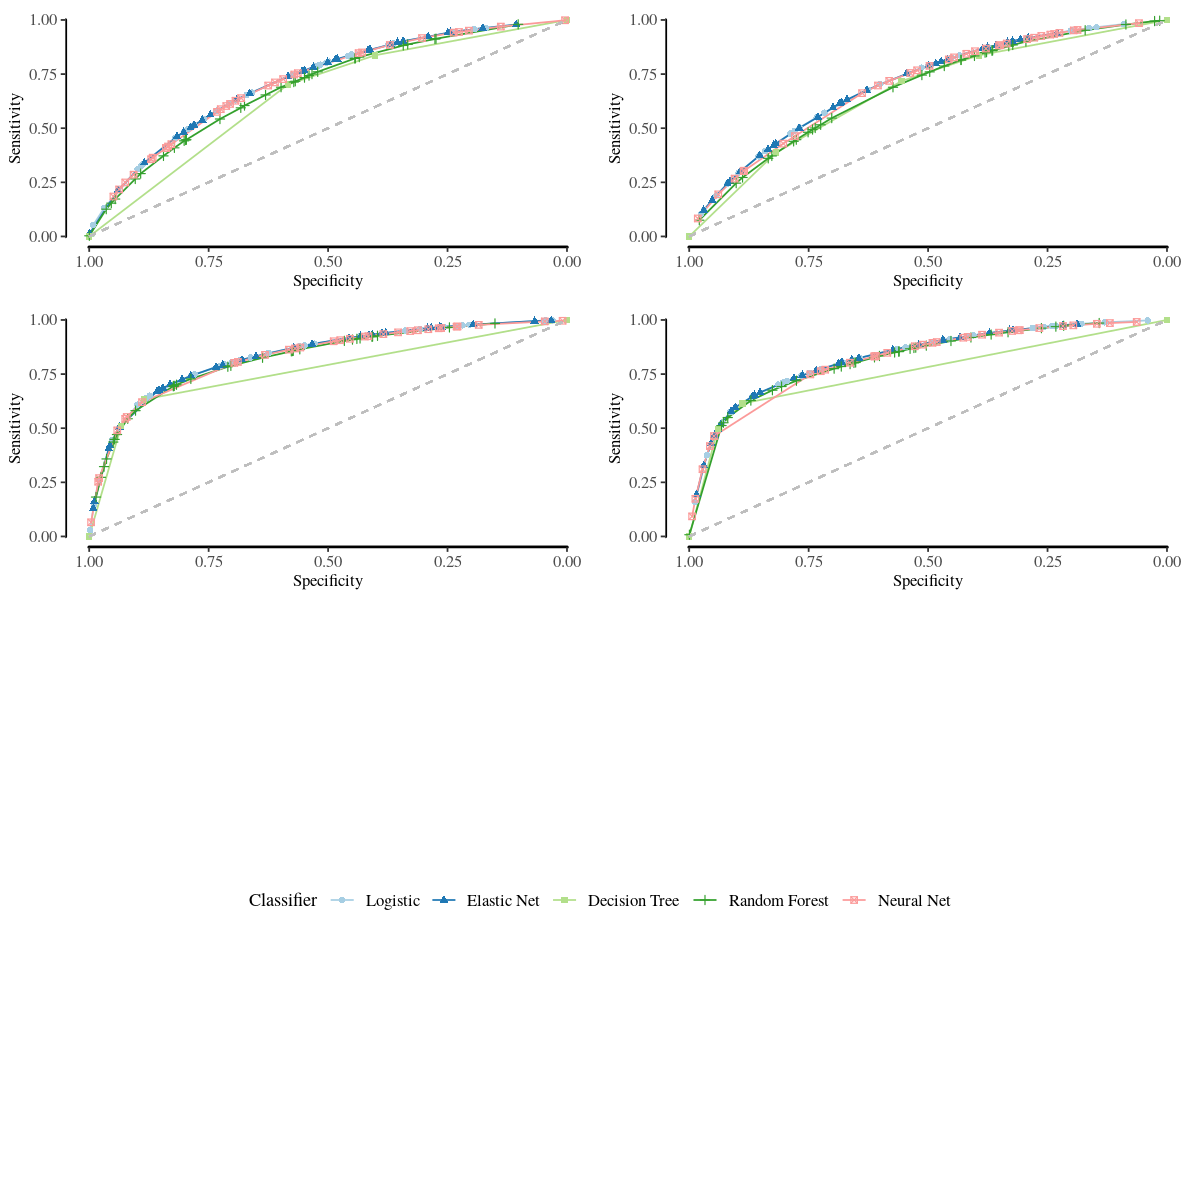

In [80]:
options(warn=-1, repr.plot.width = 10, repr.plot.height = 10)
ROC_plots <- plot_grid(ROC.grade3.read + theme(legend.position="none"),
                       ROC.grade3.num + theme(legend.position="none"),
                       ROC.grade5plus.read + theme(legend.position="none"),
                       ROC.grade5plus.num+ theme(legend.position="none"))

legend <- get_legend(ROC.grade5plus.num + theme(legend.position="bottom"))
plot_grid(ROC_plots, legend, nrow=2)

In [81]:
Sys.time() - start.time

Time difference of 1.193484 hours

Done!